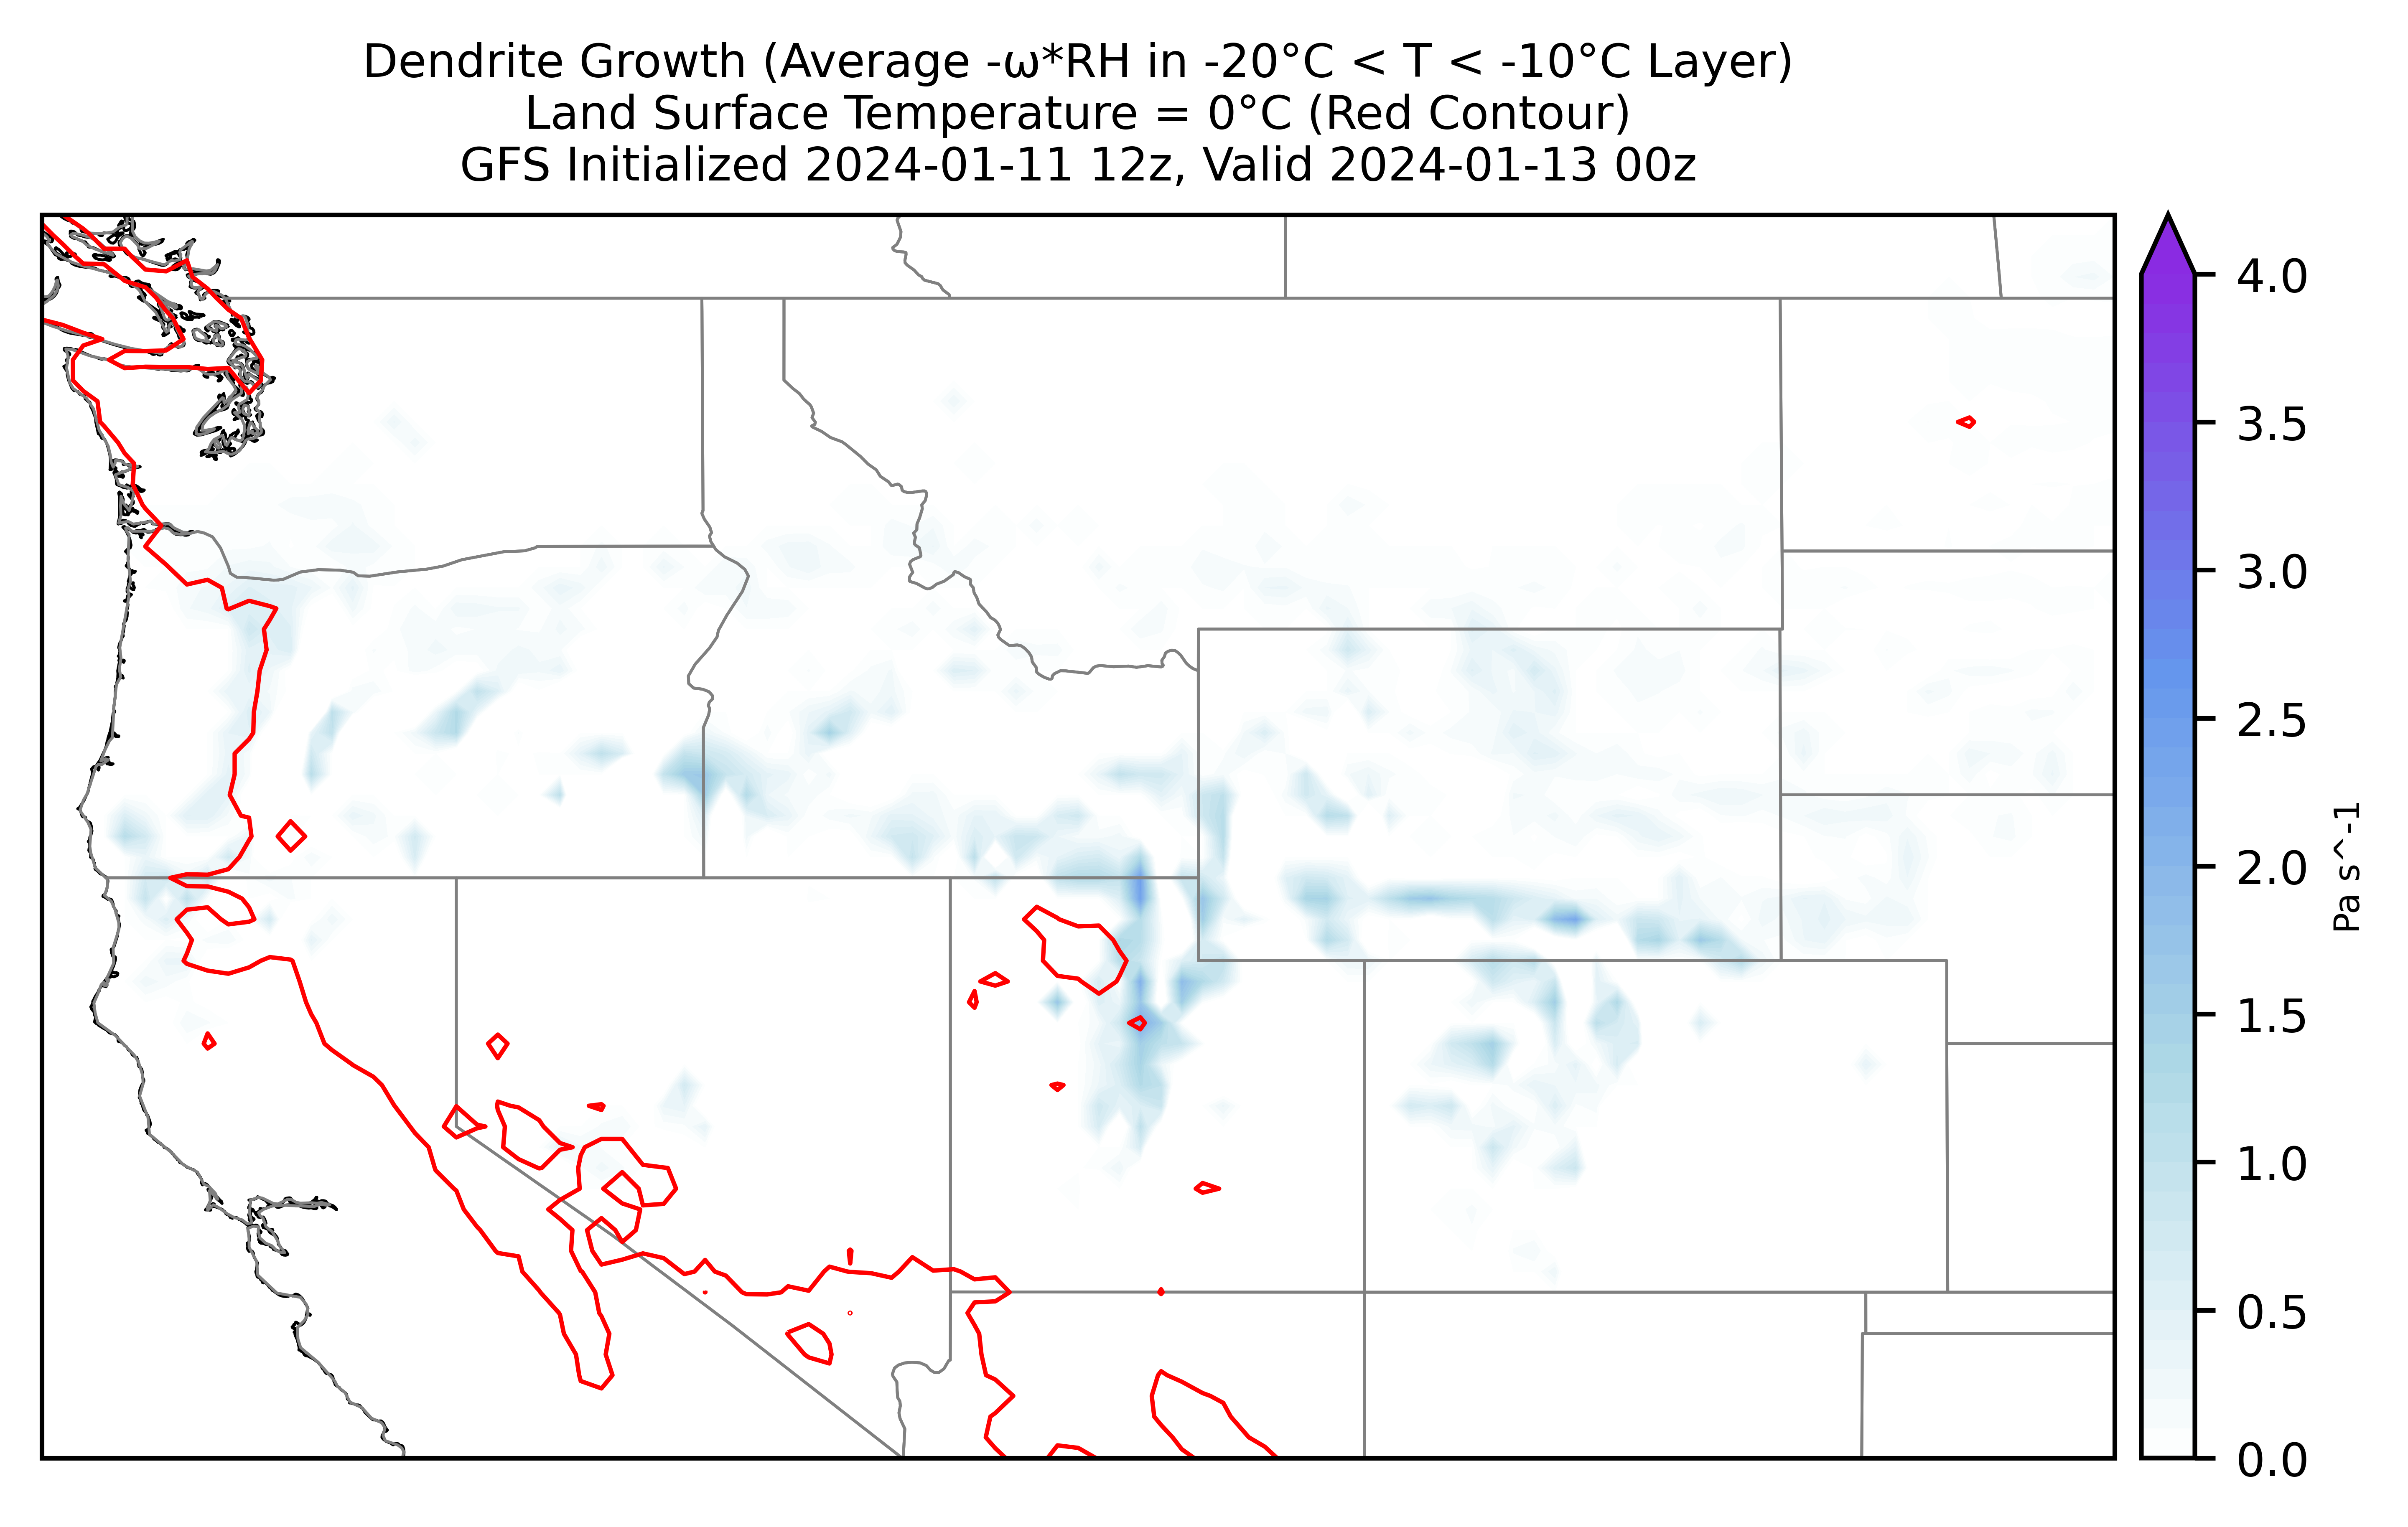

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  5 12:35:34 2024

@author: sambrandt
"""

# Libaries ####################################################################

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap

# Inputs ######################################################################

# Select time (must be contained in the latest GFS run)
year=2024
month=1
day=13
hour=0

# Domain bounds (in degrees)
north=50
south=35
east=-100
west=-125

# Toggle option for 0C land surface isotherm
Plot_0C_Isotherm=True

# Data ########################################################################

# Use 0.25 degree grid of the latest GFS run
url='https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.xml'

# Create lat/lon grid
lat=np.flip(np.arange(south,north+0.25,0.25))
lon=np.arange(west,east+0.25,0.25)
lon,lat=np.meshgrid(lon,lat)

# Data Download
# Define location of the data
best_gfs=TDSCatalog(url)
best_ds=list(best_gfs.datasets.values())[0]
ncss=best_ds.subset()
# Create a datetime object to specify the output time that you want
valid=datetime(year,month,day,hour)
# Establish a query for the data
query = ncss.query()
# Trim data to location/time of interest
query.lonlat_box(north=north,south=south,east=east,west=west).time(valid)
# Specify that output needs to be in netcdf format
query.accept('netcdf4')
# Specify the variables that you want
query.variables('Relative_humidity_isobaric','Vertical_velocity_pressure_isobaric','Temperature_isobaric','Categorical_Snow_surface','Temperature_surface')
# Retrieve the data using the info from the query
data=ncss.get_data(query)
data=xr.open_dataset(NetCDF4DataStore(data))

# Snow mask array (equals 1 where GFS thinks snow is falling, 0 otherwise)
snow=np.array(data['Categorical_Snow_surface'])[0,:,:]

# Temperature grid
T=np.array(data['Temperature_isobaric'])[0,:,:,:]
# Vertical velocity grid
omega=np.array(data['Vertical_velocity_pressure_isobaric'])[0,:,:,:]
# Relative humidity grid
rh=np.array(data['Relative_humidity_isobaric'])[0,:,:,:]/100
# Land/water surface temperature grid
Ts=np.array(data['Temperature_surface'])[0,:,:]

# Initialize the DGZ growth parameter array
dgz_growth=np.zeros((len(T[0,:,0]),len(T[0,0,:])))

# Loop through every grid point
for i in range(0,len(T[0,:,0])):
    for j in range(0,len(T[0,0,:])):
        # Find the part of the column that is in the DGZ
        indices=np.where(np.logical_and(T[:,i,j]>-20+273.15,T[:,i,j]<-10+273.15))[0]
        # Apply the conditions and fill in the corresponding value for the 
        # DGZ growth parameter
        dgz_growth[i,j]=snow[i,j]*np.mean(rh[indices,i,j]*omega[indices,i,j])

# Plotting ####################################################################

# Create a nice custom colormap
cmap=LinearSegmentedColormap.from_list('custom_cmap',['white','lightblue','cornflowerblue','blueviolet'],N=256)

# Create plot
fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(),'adjustable':'box'},dpi=1000)

# Add geographic borders
ax.coastlines(lw=0.5,edgecolor='gray')
ax.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='gray',linewidth=0.5)

# Plot the data
pcm1=ax.contourf(lon,lat,-dgz_growth,np.arange(0,4.1,0.1),cmap=cmap,extend='max')
# Logic for isotherm toggle
if Plot_0C_Isotherm==True:
    alpha=1
    title='Land Surface Temperature = 0°C (Red Contour)\n'
elif Plot_0C_Isotherm==False:
    alpha=0
    title=''
ax.contour(lon,lat,Ts,[273.15],colors='red',linewidths=0.75,alpha=alpha)

# Create axis for the colorbar
cax=fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# Add colorbar
cbar=plt.colorbar(pcm1,cax=cax)
# Add colorbar label
cbar.ax.set_ylabel('Pa s^-1',fontsize=6)
# Clean up colorbar tick marks
cbar.ax.set_yticks(np.arange(0,4.5,0.5))
cbar.ax.tick_params(labelsize=8)

# Plot title
ax.set_title('Dendrite Growth (Average -ω*RH in -20°C < T < -10°C Layer)\n'+title+'GFS Initialized '+ncss.metadata.time_span['begin'][0:10]+' '+ncss.metadata.time_span['begin'][11:13]+'z, Valid '+str(valid)[0:13]+'z',fontsize=8)
# ax.text(lon[-2,-2],lat[-2,-2],'Map By Sam Brandt\nGitHub: SamBrandtMeteo',fontsize=4,ha='right',va='bottom')

fig.savefig('WA_dendrite.png', dpi=200)

In [2]:
pip install siphon

  Using cached siphon-0.9-py2.py3-none-any.whl (69 kB)
Note: you may need to restart the kernel to use updated packages.
